# Тестовое задание

In [5]:
!python -m pip install psycopg2

In [54]:
from sqlalchemy import create_engine
import pandas as pd


POSTGRES_ADDRESS = '***' ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = '***'
POSTGRES_USERNAME = '***' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES USERNAME 
POSTGRES_PASSWORD = '***' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD POSTGRES_DBNAME = 'database' ## CHANGE THIS TO YOUR DATABASE NAME 
POSTGRES_DBNAME = '***'
# A long string that contains the necessary Postgres login information 
postgres_str = ('postgresql://{username}:{password}@{ipaddress}/{dbname}'
                .format(username=POSTGRES_USERNAME,                        
                        password=POSTGRES_PASSWORD,      
                        ipaddress=POSTGRES_ADDRESS, 
                        port=POSTGRES_PORT, 
                        dbname=POSTGRES_DBNAME))
# Create the connection 
psql = create_engine(postgres_str)

# Запрос на все таблицы
query = '''
SELECT *
FROM INFORMATION_SCHEMA.TABLES
'''

df = pd.read_sql(query, psql)
# print(df)
for table_name in df.loc[df['table_schema'] == 'public', 'table_name']:
    print(table_name)

df['table_schema'].unique()

alembic_version
products2
size
revenue
products
orders
kurs
product_groups
kurs2
line_items
customers
inv_customers
inv_orders
kurs3
kurs4
t
t1
student
ad_costs
orders2017


array(['pg_catalog', 'public', 'information_schema', 'school'],
      dtype=object)

# 1. Продажи растут или падают?
<br>
<details>
  <summary> <i>Спойлер-ответ (нажмите)</i> </summary>
  <!-- have to be followed by an empty line! -->
    
<b>Растут! Наклон тренда положительный.</b>
    
  </details>
</details>

  order_y order_m  total_sales  yyyy_mm
0    2014       1   14236.8950  2014-01
1    2014      10   31453.3930  2014-10
2    2014      11   78628.7167  2014-11
3    2014      12   69545.6205  2014-12
4    2014       2    4519.8920  2014-02 



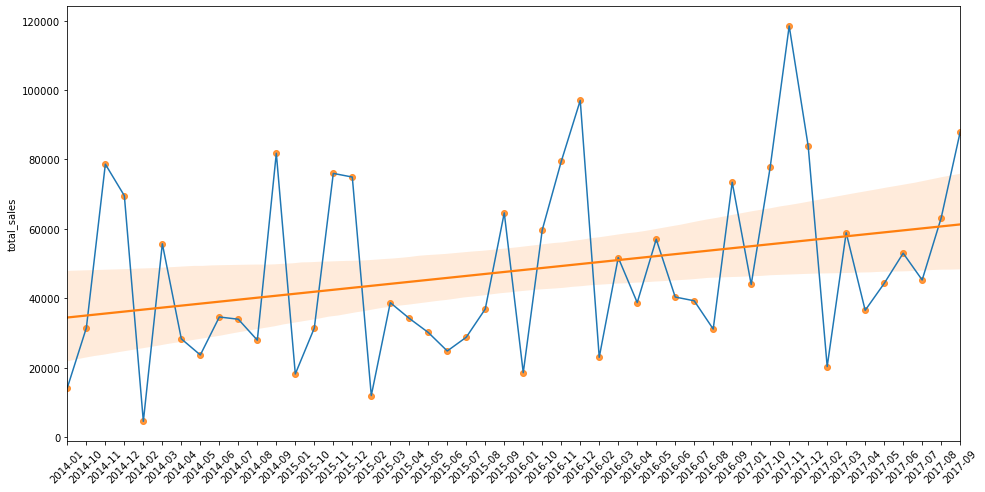

In [126]:
from matplotlib import pyplot
import seaborn as sns


query = '''
select
    cast(cast(date_part('year', order_date) as int) as varchar(4)) as order_y,
    cast(cast(date_part('month', order_date) as int) as varchar(2)) as order_m,
    sum(sales) as total_sales
from public.orders
group by 1, 2
order by 1, 2
'''

# Получаем дф
df = pd.read_sql(query, psql)
df['yyyy_mm'] = df[['order_y', 'order_m']].apply(lambda x: f'{x[0]}-0{x[1]}' if len(x[1]) == 1 else f'{x[0]}-{x[1]}', axis=1)
df.index
print(df.head(), '\n')

# Построим динамику продаж по месяцам (масштаб графика не совсем верный, тк не все месяца есть в выборке)
fig, ax = pyplot.subplots(figsize=(16, 8))
pyplot.xticks(rotation=45)
ax = sns.lineplot(data=df, x='yyyy_mm', y="total_sales")
ax = sns.regplot(x=df.index, y="total_sales", data=df)

<b>Ответ:</b><br>Растут! Наклон тренда положительный.

# 2. Как меняется средний чек?
<br>
<details>
  <summary> <i>Спойлер-ответ (нажмите)</i> </summary>
  <!-- have to be followed by an empty line! -->
    
<b>Тренд изменения среднего чека отрицательный (не сильно). Но учитывая что мы анализируем почти 4 года, можно было бы учесть инфляцию и получить явно плохой результат по среднему чеку.</b>
    
  </details>
</details>

  order_y order_m    avg_bill  yyyy_mm
0    2014       1  444.902969  2014-01
1    2014      10  403.248628  2014-10
2    2014      11  520.719978  2014-11
3    2014      12  493.231351  2014-12
4    2014       2  161.424714  2014-02 

count     48.000000
mean     457.977137
std      104.583704
min      161.424714
25%      387.299104
50%      440.370613
75%      522.731300
max      784.380408
Name: avg_bill, dtype: float64 



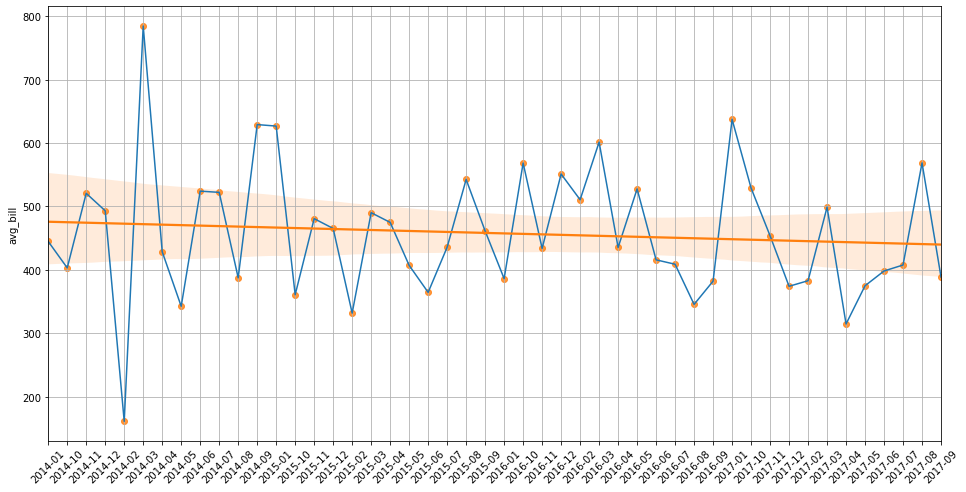

In [132]:
query = '''
select
    cast(cast(date_part('year', order_date) as int) as varchar(4)) as order_y,
    cast(cast(date_part('month', order_date) as int) as varchar(2)) as order_m,
    avg(sales) as avg_bill
from public.orders
group by 1, 2
order by 1, 2
'''

# Получаем дф
df = pd.read_sql(query, psql)
df['yyyy_mm'] = df[['order_y', 'order_m']].apply(lambda x: f'{x[0]}-0{x[1]}' if len(x[1]) == 1 else f'{x[0]}-{x[1]}', axis=1)
print(df.head(), '\n')
print(df['avg_bill'].describe(), '\n')

# Построим динамику продаж по месяцам (масштаб графика не совсем верный, тк не все месяца есть в выборке)
fig, ax = pyplot.subplots(figsize=(16, 8))
pyplot.xticks(rotation=45)
ax = sns.lineplot(data=df, x='yyyy_mm', y="avg_bill")
ax = sns.regplot(x=df.index, y="avg_bill", data=df)
pyplot.grid()

<b>Ответ:</b><br> Тренд изменения среднего чека отрицательный (не сильно). Но учитывая что мы анализируем почти 4 года, можно было бы учесть инфляцию и получить явно плохой результат по среднему чеку.

# 3. Доходность категорий и подкатегорий
<br>
<details>
  <summary> <i>Спойлер-ответ (нажмите)</i> </summary>
  <!-- have to be followed by an empty line! -->
    
<b>Самая доходная категория - Technology.<br>
    Самая доходная подкатегория - Phones</b>
    
  </details>
</details>

In [155]:
query = '''
select
    product_category,
    product_subcategory,
    sum(amount) as revenue
from (
    --Таблица продаж продуктов в разрезе заказов
    select
        a.order_id,
        a.product_id,
        b.category as product_category,
        b.sub_category as product_subcategory,
        b.price as product_price,
        a.quantity,
        a.amount    
    from public.line_items as a
    left join
        (
        select
            *
        from public.products
        ) as b on a.product_id = b.id
    --Таблица продаж продуктов в разрезе заказов
        ) as sales_t
group by 1, 2
order by 3 desc
'''

# Получаем дф (доходность подкатегорий)
df = pd.read_sql(query, psql)
print(df, '\n')

# Доходность категорий
df_cat = df.groupby(by='product_category')['revenue'].sum().sort_values(ascending=False)
df_cat

   product_category product_subcategory      revenue
0        Technology              Phones  330007.0540
1         Furniture              Chairs  328167.7310
2   Office Supplies             Storage  223299.2280
3         Furniture              Tables  206965.5320
4   Office Supplies             Binders  203322.6730
5        Technology            Machines  189238.6310
6        Technology         Accessories  166986.0220
7        Technology             Copiers  149528.0300
8         Furniture           Bookcases  114879.9963
9   Office Supplies          Appliances  107532.1610
10        Furniture         Furnishings   91418.7840
11  Office Supplies               Paper   78384.4060
12  Office Supplies            Supplies   46673.5380
13  Office Supplies                 Art   27118.7920
14  Office Supplies           Envelopes   16476.4020
15  Office Supplies              Labels   12486.3120
16  Office Supplies           Fasteners    3024.2800 



product_category
Technology         835759.7370
Furniture          741432.0433
Office Supplies    718317.7920
Name: revenue, dtype: float64

<b>Ответ:</b><br>Самая доходная категория - Technology.<br>Самая доходная подкатегория - Phones.

# 4. Динамика продаж за последние 3 месяца
<br>
<details>
  <summary> <i>Спойлер-ответ (нажмите)</i> </summary>
  <!-- have to be followed by an empty line! -->
    
<b>Вывод:</b><br>Осенью возросли продажи мебели для домашнего офиса в Калифорнии и Нью-Йорке. Пики заказов приходятся примерно на выходные дни.
    
  </details>
</details>
<br>
План:
<ol>
    <li>Соберем таблицу продаж и обогатим её всеми данными в БД.</li>
    <li>Посмотрим динамику дохода по дням (добавив недостающие даты) за все время, год, полгода, 3м.</li>
    <li>Из каких факторов складывался доход в последние 3 месяца? Из каких в остальные месяцы года?</li>
</ol>

In [175]:
# 1. Соберем таблицу продаж и обогатим её всеми данными в БД.
query = '''
--Полная таблица продаж со всеми данными
select
    a.order_id,
    a.order_date,
    a.ship_date,
    a.ship_mode,
    a.customer_id,
    a.customer_name,
    a.customer_segment,
    a.customer_country,
    a.customer_state,
    a.customer_city,
    a.customer_zipcode,
    a.customer_region,
    b.product_id,
    b.product_category,
    b.product_subcategory,
    b.product_price,
    b.product_quantity,
    b.total_paid
from (
        --Заказы по датам с данными покупателей
        select
            a.id as order_id,
            a.order_date,
            a.ship_date,
            a.ship_mode,
            a.customer_id,
            b.name as customer_name,
            b.segment as customer_segment,
            b.country as customer_country,
            b.state as customer_state,
            b.city as customer_city,
            b.postal_code as customer_zipcode,
            b.region as customer_region
        from public.orders as a
        left join
            (
            select
                *
            from public.customers
            ) as b on a.customer_id = b.id
        --Заказы по датам с данными покупателей
        ) as a
left join (
            --Таблица продаж продуктов в разрезе заказов
            select
                a.order_id,
                a.product_id,
                b.category as product_category,
                b.sub_category as product_subcategory,
                b.price as product_price,
                a.quantity as product_quantity,
                a.amount as total_paid
            from public.line_items as a
            left join
                (
                select
                    *
                from public.products
                ) as b on a.product_id = b.id
            --Таблица продаж продуктов в разрезе заказов
            ) as b on a.order_id = b.order_id
order by order_date
--Полная таблица продаж со всеми данными
'''

# Получаем дф
df = pd.read_sql(query, psql)

# Конвертация столбцов в формат времени
df['order_date'] = pd.to_datetime(df['order_date'])
df['ship_date'] = pd.to_datetime(df['ship_date'])

df.head()

,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,customer_segment,customer_country,customer_state,customer_city,customer_zipcode,customer_region,product_id,product_category,product_subcategory,product_price,product_quantity,total_paid
0,CA-2014-103800,2014-01-03,2014-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Indiana,New Albany,47150,Central,OFF-PA-10000174,Office Supplies,Paper,8.224,2,16.448
1,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Illinois,Naperville,60540,Central,OFF-LA-10003223,Office Supplies,Labels,3.928,3,11.784
2,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Illinois,Naperville,60540,Central,OFF-ST-10002743,Office Supplies,Storage,113.640,3,272.736
3,CA-2014-112326,2014-01-04,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Illinois,Naperville,60540,Central,OFF-BI-10004094,Office Supplies,Binders,1.770,2,3.540
4,CA-2014-141817,2014-01-05,2014-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,New Jersey,Vineland,8360,East,OFF-AR-10003478,Office Supplies,Art,6.512,3,19.536


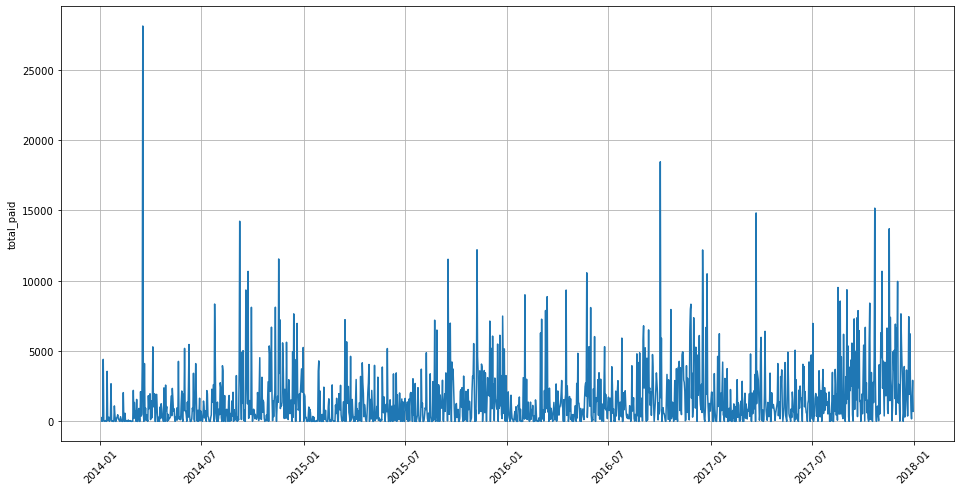

In [183]:
# 2. Посмотрим динамику дохода по дням (добавив недостающие даты)
income = df.groupby(by='order_date')['total_paid'].sum()

# Заполним пропуски дат нулевыми значениями
idx = pd.date_range('2014-01-03', '2017-12-30')
income = income.reindex(idx, fill_value=0)

# Посмотрим полную динамику дохода по дням
fig, ax = pyplot.subplots(figsize=(16, 8))
pyplot.xticks(rotation=45)
ax = sns.lineplot(data=income)
pyplot.grid()

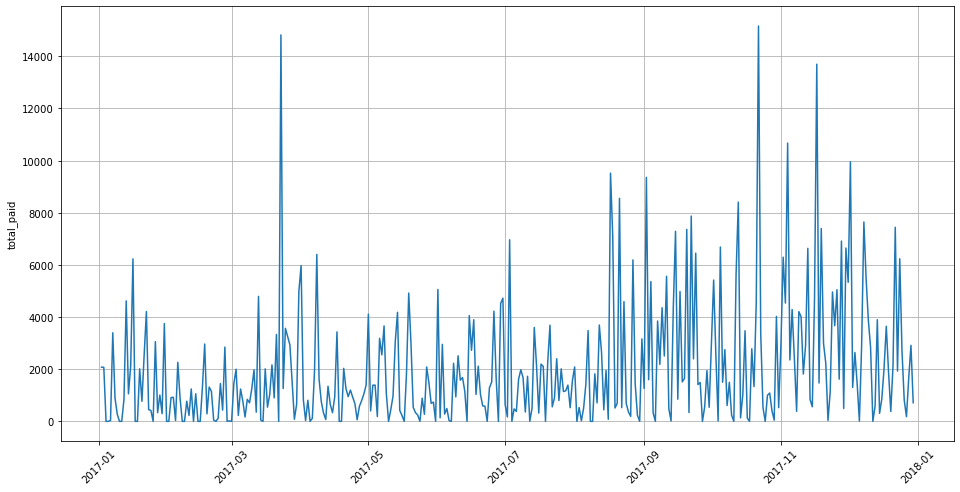

In [185]:
# Динамика дохода за последний год
income_year = income[income.index > pd.Timestamp('2017-01-01')].copy(deep=True)
fig, ax = pyplot.subplots(figsize=(16, 8))
pyplot.xticks(rotation=45)
ax = sns.lineplot(data=income_year)
pyplot.grid()

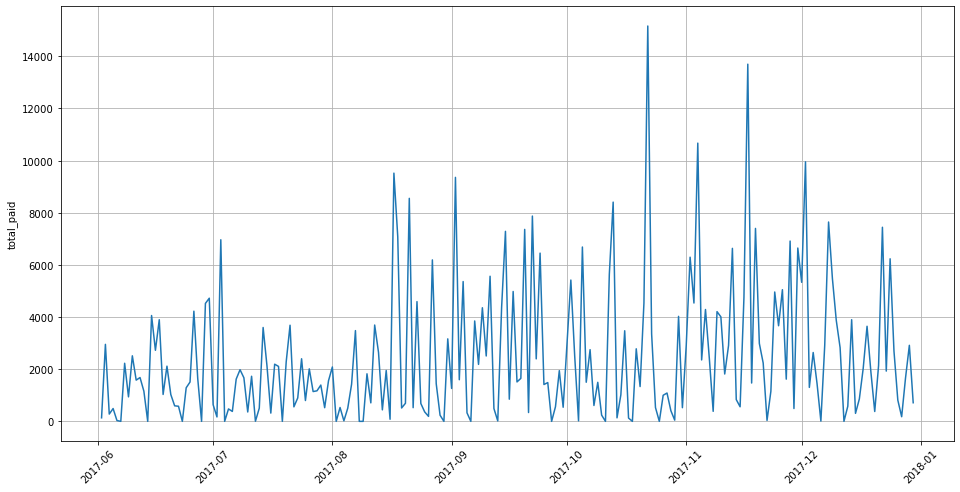

In [186]:
# Динамика дохода за последние полгода
income_halfyear = income[income.index > pd.Timestamp('2017-06-01')].copy(deep=True)
fig, ax = pyplot.subplots(figsize=(16, 8))
pyplot.xticks(rotation=45)
ax = sns.lineplot(data=income_halfyear)
pyplot.grid()

2017-10-22    15158.8770
2017-11-17    13694.8828
2017-11-04    10668.0960
2017-12-02     9951.1820
2017-10-13     8405.8020
2017-12-08     7643.0410
2017-12-22     7442.0210
2017-11-19     7397.2720
2017-11-28     6912.9440
2017-10-05     6684.6160
Name: total_paid, dtype: float64

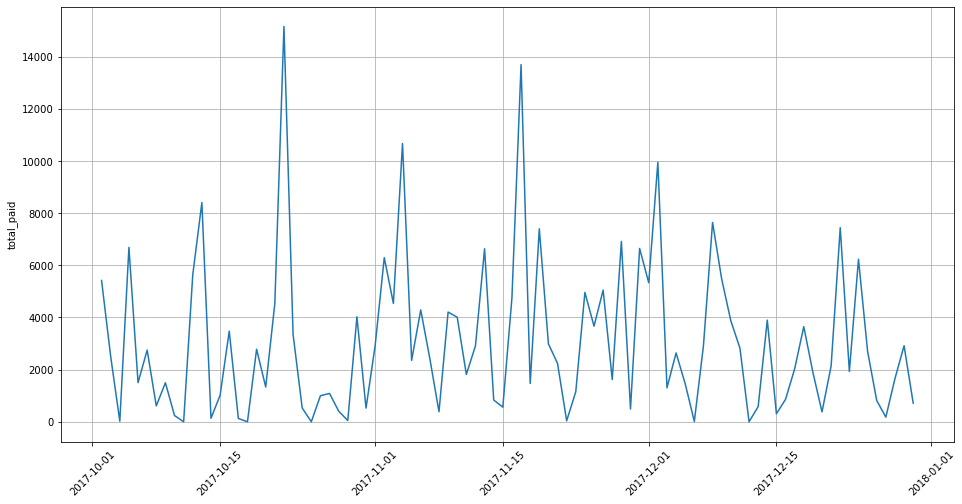

In [189]:
# Динамика дохода за последние 3 месяца
income_3month = income[income.index > pd.Timestamp('2017-10-01')].copy(deep=True)
fig, ax = pyplot.subplots(figsize=(16, 8))
pyplot.xticks(rotation=45)
ax = sns.lineplot(data=income_3month)
pyplot.grid()

# Посмотрим даты топ дохода
income_3month.sort_values(ascending=False).head(10)

Продажи явно начали расти в конце лета 2017. Осенью начинается пора скидок - может это ключевой фактор? Хотя, во-первых - в нашем магазине цены постоянны (судя по БД), во-вторых - в даты черной пятницы, когда наплыв должен быть максимален - это не так.

В общем, как вариант - пора предстоящих праздников. Люди тратят больше в эти дни.

Копнём глубже.

**Из каких факторов складывался основной доход в топовые дни? Из каких складывался в другие дни?**

In [201]:
# Данные дохода за 3 месяца
df_2017_3m = df.loc[df['order_date'] > pd.Timestamp('2017-10-01')].copy(deep=True)

# Данные дохода за другие месяцы в году
df_2017_other = df.loc[(df['order_date'] < pd.Timestamp('2017-10-01')) & (df['order_date'] > pd.Timestamp('2017-01-01'))].copy(deep=True)

# Фичи, которые могут влиять на доход
cols = ['ship_mode', 'customer_segment', 'customer_country', 'customer_state', 'customer_city', 'customer_region',
        'product_category', 'product_subcategory']

# Создадим словарь
dct_2017_3m = {}
for column in cols:
    # Получим долю дохода, которую принесли значения рассматриваемой группировки
    grp = df_2017_3m.groupby(by=column)['total_paid'].sum().sort_values(ascending=False)
    full_sum = grp.sum()
    n_grp = round(grp / full_sum, 2).head(5)
    dct_2017_3m[column] = n_grp   # Добавим данные в словарь
    
# Создадим словарь (Тоже самое для второго среза данных)
dct_2017_other = {}
for column in cols:
    # Получим долю дохода, которую принесли значения рассматриваемой группировки
    grp = df_2017_other.groupby(by=column)['total_paid'].sum().sort_values(ascending=False)
    full_sum = grp.sum()
    n_grp = round(grp / full_sum, 2).head(5)
    dct_2017_other[column] = n_grp   # Добавим данные в словарь
    
# Цикл вывода данных для анализа
for col in cols:
    print(f'Доля дохода на каждое значение {col}:\n')
    print('Первые месяцы - ', dct_2017_other[col], '\n')
    print('Последние 3 месяца - ', dct_2017_3m[col])
    print('---\n\n\n')

Доля дохода на каждое значение ship_mode:

Первые месяцы -  ship_mode
Standard Class    0.53
Second Class      0.23
First Class       0.18
Same Day          0.06
Name: total_paid, dtype: float64 

Последние 3 месяца -  ship_mode
Standard Class    0.56
First Class       0.20
Second Class      0.17
Same Day          0.07
Name: total_paid, dtype: float64
---



Доля дохода на каждое значение customer_segment:

Первые месяцы -  customer_segment
Consumer       0.46
Corporate      0.34
Home Office    0.21
Name: total_paid, dtype: float64 

Последние 3 месяца -  customer_segment
Consumer       0.44
Corporate      0.32
Home Office    0.24
Name: total_paid, dtype: float64
---



Доля дохода на каждое значение customer_country:

Первые месяцы -  customer_country
United States    1.0
Name: total_paid, dtype: float64 

Последние 3 месяца -  customer_country
United States    1.0
Name: total_paid, dtype: float64
---



Доля дохода на каждое значение customer_state:

Первые месяцы -  customer_state
C

Исходя из полученных данных можно сделать <b>Вывод:</b><br>Осенью возросли продажи мебели для домашнего офиса в Калифорнии и Нью-Йорке. Пики заказов приходятся примерно на выходные дни.